<a href="https://colab.research.google.com/github/paulamyrian/OOV_usingRNNs/blob/main/RNN_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Exemplo de Uso de RNN**

**REDES NEURAIS RECORRENTES**

Instrutora Paula Pedroso

**PROBLEMA:** Palavras Fora do Vocabulário

Quando uma palavra que não está no conjunto de treinamento ocorre em dados reais, isso causa um problema. É um problema muito comum em PLN e pode ser visto na classificação de textos, reconhecimento de entidades nomeadas, recuperação de informações, etc.

As razões para que isso ocorra envolvem erros de digitação, gírias e vocabulários diferentes.



Iremos utilizar um conjunto de bibliotecas para poder nos auxiliar nesse processo de reconhecimento das palavras OOVs. 

In [ ]:
#O NumPy oferece funções matemáticas abrangentes, geradores de números aleatórios, rotinas de álgebra linear, transformadas de Fourier e muito mais.
import numpy
from numpy import array
#spaCy é uma biblioteca para PLN. 
#possui features como tokenizador, POS-tagger, NER, word vectors pré-treinados, dentre outras coisas.
import spacy
from spacy.vocab import Vocab
#TensorFlow é uma biblioteca de código aberto para aprendizado de máquina.
import tensorflow as tf
#Keras é um API de alto nível construído sobre o TensorFlow 
#projetado para permitir experimentação rápida com redes neurais profundas.
from tensorflow import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
#O módulo pickle implementa protocolos binários para serializar e desserializar uma estrutura de objeto Python.
import pickle
#NLTK significa Natural Language Toolkit, que é algo como uma caixa de ferramentas para linguagem natural.
import nltk
from nltk.corpus import stopwords


Lendo dados de texto para treinamento. É importante usar um corpus que possua um linguajar próximo às palavras que irá utilizar.

**Preparação do modelo**

# **Incorporação do Corpus de treinamento**

In [ ]:
data = open('/content/comments.csv').read()[:100000]
data

'status_message\nVamos tomar chopp hoje😍\n"Todo mundo curte um hot roll. E quem negar, mentiu. 😎 \n\nAbrimos às 18h00!\n🎌 Batista Campos - Rua dos Pariquis, 1712\n🎌 Av. Senador Lemos, 356 🎌 Av. Duque de Caxias, 510 \nDelivery:\n2121-4463"\nMesa cheia é mesa alegre!\nNosso Filé com Molho de Vinho é fabuloso! Ele ainda acompanha um delicioso risoto de funghi. Venha apreciar os sabores do Vegas! #VegasRestaurante #VivaVegas\n"Daqui a pouco tem Malino’s Hein!\n🍔🍺🍟😍"\n"Você sabia que além de hambúrgueres,temos também Coquetel de Fruta😲\nIsso mesmo, então vc já sabe☺☺☺"\n"Que esse é um dos pratos mais famosos e respeitados aqui em Belém, todos já sabem. Mas só dá para descobrir o motivo provando. Venha experimentar o Vatapá do Point e se surpreenda! 😉 👏 👌\n\n👉 Point Aquários\n- Municipalidade, nº 897, esquina da Wandenkolk.\n- (91) 3223-1686 / 3085-7229.\n- Domingo – 8h às 17h. Segunda a sábado – 8h às 22h30."\n"30ª ED. DO T.D.O. (Tributo Duplo Oficial)\nLEGIÃO URBANA E CHARLIE BROWN JR\n\nH

Para modelar a língua e possibilitar que a máquina a entenda, são necessários pré-processamentos que abstraem e estruturam a língua, deixando apenas o que é informação relevante. Esse pré-processamento reduz o vocabulário e torna os dados menos esparsos, característica conveniente para o processamento computacional.

O processo de tokenização tem como objetivo separar palavras ou sentenças em unidades. A tokenização lexical marca cada palavra como um token no texto, identificando-a mesmo se tiver encostada em alguma pontuação. Um exemplo de texto tokenizado lexicalmente seria:



> Começando uma frase. 

> ['começando','uma','frase','.']


A tokenização sentencial identifica e marca sentenças. Um exemplo seria:



> Sentença primeira. Segunda setença. Terceira setença.


> ['Sentença primeira.','Segunda setença.','Terceira setença.']


A normalização é importante por começar a estruturar o texto, já que os processamentos seguintes atuam em cima de unidades sentenciais e lexicais.








# **Tratamento do Corpus**

In [ ]:
#função para preparar dados de texto em sequências para treinamento 
def data_sequencing(data):   
    #  codificar sequências de palavras (tokenização)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([data])
    with open('tokenizer.pkl', 'wb') as f: # salvando o tokenizer para usar depois
        pickle.dump(tokenizer, f)

    encoded = tokenizer.texts_to_sequences([data])[0]
    # recuperar o tamanho do vocabulário
    vocab_size = len(tokenizer.word_index) + 1
    print('Vocabulary Size: %d' % vocab_size)
    
    # criar sequências baseadas em linha
    sequences = list()
    rev_sequences = list()
    for line in data.split('.'):
        encoded = tokenizer.texts_to_sequences([line])[0]
        rev_encoded = encoded[::-1]
        for i in range(1, len(encoded)):
            sequence = encoded[:i+1]
            rev_sequence = rev_encoded[:i+1]
            sequences.append(sequence)
            rev_sequences.append(rev_sequence)
    print('Total Sequences: %d' % len(sequences))
    
    
    #comprimento máximo da sequência 
    max_length = max([len(seq) for seq in sequences])
    with open('max_length.pkl', 'wb') as f: # salvando o comprimento máximo para usar depois
        pickle.dump(max_length, f)
    print('Max Sequence Length: %d' % max_length)

    # pad_sequences é usado para garantir que todas as sequências em uma lista tenham o mesmo comprimento
    sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
    # dividido em elementos de entrada e saída
    sequences = array(sequences)
    X, y = sequences[:,:-1],sequences[:,-1]
    

    return X,y,max_length,vocab_size

Retornando sequências diretas e reversas junto com o comprimento máximo da sequência dos dados

In [ ]:
X,y,max_length,vocab_size = data_sequencing(data)

Vocabulary Size: 3590
Total Sequences: 15938
Max Sequence Length: 229


# **Definição do modelo**

In [ ]:
# definir modelo de sequência direta
model = Sequential()
model.add(Embedding(vocab_size,100, input_length=max_length-1))
model.add(SimpleRNN(100))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 228, 100)          359000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 3590)              362590    
                                                                 
Total params: 741,690
Trainable params: 741,690
Non-trainable params: 0
_________________________________________________________________
None


# **Treinamento do modelo**

In [ ]:
#compilar a rede de sequência direta
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Treina o modelo para um número fixo de epochs (iterações em um conjunto de dados).
model.fit(X, y,batch_size=100, epochs=50, verbose=2)
# salve o modelo em arquivo h5
# Um arquivo h5 é um arquivo de dados salvo no Formato de Dados Hierárquico (HDF). Contém matrizes multidimensionais de dados científicos
model.save('model_rnn.h5')

Epoch 1/50
160/160 - 27s - loss: 7.1572 - accuracy: 0.0363 - 27s/epoch - 170ms/step
Epoch 2/50
160/160 - 29s - loss: 6.6893 - accuracy: 0.0383 - 29s/epoch - 181ms/step
Epoch 3/50
160/160 - 26s - loss: 6.3352 - accuracy: 0.0537 - 26s/epoch - 165ms/step
Epoch 4/50
160/160 - 26s - loss: 5.9001 - accuracy: 0.0907 - 26s/epoch - 160ms/step
Epoch 5/50
160/160 - 25s - loss: 5.4312 - accuracy: 0.1373 - 25s/epoch - 157ms/step
Epoch 6/50
160/160 - 25s - loss: 5.0684 - accuracy: 0.1782 - 25s/epoch - 158ms/step
Epoch 7/50
160/160 - 25s - loss: 4.6054 - accuracy: 0.2205 - 25s/epoch - 157ms/step
Epoch 8/50
160/160 - 28s - loss: 4.2123 - accuracy: 0.2629 - 28s/epoch - 176ms/step
Epoch 9/50
160/160 - 25s - loss: 3.8556 - accuracy: 0.3071 - 25s/epoch - 158ms/step
Epoch 10/50
160/160 - 26s - loss: 3.5250 - accuracy: 0.3591 - 26s/epoch - 160ms/step
Epoch 11/50
160/160 - 26s - loss: 3.4421 - accuracy: 0.3783 - 26s/epoch - 161ms/step
Epoch 12/50
160/160 - 26s - loss: 3.0631 - accuracy: 0.4355 - 26s/epoch - 

**Predição de embeddings das OOVs**

In [ ]:
#Download stop words da biblioteca NLTK.
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Modelo pré-treinado com embeddings em português para a biblioteca spaCy
!python -m spacy download pt_core_news_md

2022-11-05 13:40:00.560823: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.4 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')


# **Carregar o modelo tratado**

In [ ]:
# carregar o modelo treinado com base no RNN
model = load_model('/content/model_rnn.h5')

#carregar o tokenizer e max_length
with open('/content/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
    
with open('/content/max_length.pkl', 'rb') as f:
    max_length = pickle.load(f)
    
#carregando palavras irrelevantes para melhorar as previsões de palavras relevantes   
stopwords = nltk.corpus.stopwords.words('portuguese')

#carregar o modelo spacy em português optimizado
nlp = spacy.load('pt_core_news_md')

# **Criar função para gerar sequências**

In [ ]:
# gerar uma sequência usando um modelo de linguagem
def generate_seq(model, tokenizer, max_length, seed_text):
    if seed_text == "":
        return ""
    else:
        in_text = seed_text
        n_words = 1
        n_preds = 5 #número de palavras a prever para o texto inicial (pode ser qualquer valor) 
        pred_words = ""
        # gerar um número fixo de palavras
        for _ in range(n_words):
            # codificar o texto como inteiro
            encoded = tokenizer.texts_to_sequences([in_text])[0]
            # sequências de pré-pad para um comprimento fixo
            encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
            # prever probabilidades para cada palavra
            proba = model.predict(encoded, verbose=0).flatten()
            #pegue as classes de probabilidade mais altas (n_preds)
            yhat = numpy.argsort(-proba)[:n_preds] 
            # mapear palavras previstas
            out_word = ''

            for _ in range(n_preds):
                for word, index in tokenizer.word_index.items():
                    if index == yhat[_] and word not in stopwords:
                        out_word = word
                        pred_words += ' ' + out_word
                        #print(out_word)
                        break


        return pred_words

Vamos verificar algumas palavras para saber se o modelo padrão possui embedding para elas.

In [ ]:
#BANZEIRO – Onda do mar
nlp.vocab.get_vector('banzeiro')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
#ESCRITINHO – Muito parecido. Semelhante. Igual.
nlp.vocab.get_vector('escritinho')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# **Colocar textos de amostras para teste**

Colocar as palavras em uma frase para que o sistema consiga achar o embedding da palavra desconhecida através do contexto

In [ ]:
doc1 = nlp('O Barco atravessou o banzeiro sem sofrer danos')
doc2 = nlp('Alessandro é escritinho um ator da Globo.')

# **Função para criar embeddings**

In [ ]:
#Encontrar e definir embeddings para palavras OOV
def set_embedding_for_oov(doc):
    #verificando palavras oov e adicionando embeddings
    for token in doc:
        if token.is_oov == True:
            before_text = doc[:token.i].text

            pred_before = generate_seq(model, tokenizer, max_length-1, before_text).split()
            
            embedding = numpy.zeros((300,))

            i=len(before_text)
            print('Palavras previstas a partir do modelo de sequência direta:')
            for word in pred_before:
                print(word)
                embedding += i*nlp.vocab.get_vector(word)
                i= i*.5

            nlp.vocab.set_vector(token.text, embedding)
            print(token.text,nlp.vocab.get_vector(token.text)) 

In [ ]:
set_embedding_for_oov(doc1)

Palavras previstas a partir do modelo de sequência direta:
buffet
menu
prato
karaokê
mousse
banzeiro [ -64.47635     -87.33981      68.83192      38.484562     35.888676
   53.577538    -66.816376    -14.410992     -6.007527     58.80371
   92.36438      -9.231775    -83.074554    -24.189436      1.8833873
   25.681711    -54.617188    -91.63767     -13.947974      4.8483295
   68.83746      64.51637     -41.676987    -12.301951     65.64211
 -159.68423       9.086562     33.49015     -95.21148     -42.72248
   24.46715     -44.482002     74.89695      26.155186    -11.703712
   52.912975    -89.314705     83.46609     104.551       -23.072426
   43.252277    -48.111893    -31.859987    -21.2511      177.3565
   21.7375       26.142988     25.148949    -21.37669     -74.630424
  -52.44545      38.445538    -89.79812     -68.7722      -18.333313
   47.083378     88.716095    -79.73404      45.89295      -2.5014884
   66.92924       1.8813242    23.066124     29.74415      83.75575
   84

In [ ]:
set_embedding_for_oov(doc2)

Palavras previstas a partir do modelo de sequência direta:
claro
dia
escritinho [-4.45187988e+01 -5.01300049e+00 -2.98920002e+01 -2.79959869e+00
 -2.46634216e+01 -8.05620098e+00 -2.89094791e+01  1.58987989e+01
  7.70268011e+00  1.81577778e+01 -1.14081230e+01  9.40920258e+00
  4.24312782e+01 -2.98121395e+01 -1.69356022e+01 -4.59624100e+00
  9.91380095e-01  4.65372009e+01 -1.22183990e+01  7.04700012e+01
 -4.25526009e+01  1.48374023e+01  1.72970409e+01  4.17155991e+01
  1.43778658e+01  8.82726002e+00 -3.19200001e+01  3.11136017e+01
 -4.95858002e+01 -5.27463608e+01  2.33987999e+01  8.09747982e+00
  2.09530830e+01  1.61425190e+01  3.04220409e+01 -5.60759544e-01
 -2.14656029e+01  1.69723206e+01  2.52578411e+01  6.32159805e+00
 -1.17077999e+01  2.23293610e+01  9.88614082e+00  2.52693615e+01
  6.67499924e+00 -2.18299599e+01  1.54410000e+01 -3.00601215e+01
 -2.31148796e+01 -4.34987984e+01  1.75658398e+01  4.93151999e+00
 -2.23468781e+01  1.83846016e+01 -3.56760025e+01 -1.83073196e+01
 -1.099679

# **Testar a similaridade das palavras**

A função, através do contexto, conseguiu achar um vetor válido para as palavras antes desconhecidas.

Nessa etapa, vamos verificar a semelhança entre frases que contenham o significado dessas OOVs. Verificar a semelhança pelo contexto.

Testando a similaridade entre frases

In [ ]:
doc3 = nlp('Senhor, a perseverança das ondas do mar, que fazem de cada recuo um ponto de partida para um novo avanço.')

doc4 = nlp('As vezes é preciso ser como as ondas do mar, recuar para ganhar força.')

doc5 = nlp('Como ondas do mar')

In [ ]:
print(doc1, "<->", doc3, "=", doc1.similarity(doc3))
print(doc1, "<->", doc4, "=", doc1.similarity(doc4))
print(doc1, "<->", doc5, "=",doc1.similarity(doc5))

O Barco atravessou o banzeiro sem sofrer danos <-> Senhor, a perseverança das ondas do mar, que fazem de cada recuo um ponto de partida para um novo avanço. = 0.09259158185615217
O Barco atravessou o banzeiro sem sofrer danos <-> As vezes é preciso ser como as ondas do mar, recuar para ganhar força. = 0.004209054188134099
O Barco atravessou o banzeiro sem sofrer danos <-> Como ondas do mar = 0.08802868025359584


In [ ]:
doc6 = nlp('Você fica muito parecido com as pessoas que convive')

doc7 = nlp('Para muitas pessoas a felicidade é semelhante a uma bola.')

doc8 = nlp('Ninguém é igual a ninguém.')

In [ ]:
print(doc2, "<->", doc6, "=", doc1.similarity(doc6))
print(doc2, "<->", doc7, "=", doc1.similarity(doc7))
print(doc2, "<->", doc8, "=", doc1.similarity(doc8))

Alessandro é escritinho um ator da Globo. <-> Você fica muito parecido com as pessoas que convive = 0.1727255149241579
Alessandro é escritinho um ator da Globo. <-> Para muitas pessoas a felicidade é semelhante a uma bola. = 0.01820143928820385
Alessandro é escritinho um ator da Globo. <-> Ninguém é igual a ninguém. = 0.007311788470478939


Nessa etapa, através da similaridade de cosseno, vamos ver se os vetores achados para as palavras OOVs se aproximam do seu significado

Testando a similaridade entre palavras

In [ ]:
nlp('banzeiro').similarity(nlp('onda do mar'))

-0.05794341649543755

In [ ]:
nlp('banzeiro').similarity(nlp('onda'))

-0.09558590545909755

In [ ]:
nlp('banzeiro').similarity(nlp('mar'))

0.1751030014473412

In [ ]:
nlp('escritinho').similarity(nlp('muito parecido'))

0.46181413531294874

In [ ]:
nlp('escritinho').similarity(nlp('parecido'))

0.3340517898560717

In [ ]:
nlp('escritinho').similarity(nlp('semelhante'))

0.17767209936516296

# **EXTRA - Verificando a marcação gramatical**

Nessa etapa, será verificado a marcação gramatical das palavras

In [ ]:
for token in doc1:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_)

O o DET DET det X
Barco Barco PROPN PROPN nsubj Xxxxx
atravessou atravessar VERB VERB ROOT xxxx
o o DET DET det x
banzeiro banzeiro NOUN NOUN obj xxxx
sem sem SCONJ SCONJ mark xxx
sofrer sofrer VERB VERB advcl xxxx
danos dano NOUN NOUN obj xxxx


In [ ]:
for token in doc2:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_)

Alessandro Alessandro PROPN PROPN nsubj Xxxxx
é ser AUX AUX cop x
escritinho escritinho ADJ ADJ ROOT xxxx
um um DET DET det xx
ator ator NOUN NOUN nsubj xxxx
da de o ADP ADP case xx
Globo globo NOUN NOUN nmod Xxxxx
. . PUNCT PUNCT punct .


# **EXTRA - Olhando graficamente a questão das similaridades**

Colocar as palavras em uma matriz

In [ ]:
!pip install whatlies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.4 MB/s 
     |████████████████████████████████| 11.2 MB 38.7 MB/s 
     |████████████████████████████████| 24.2 MB 1.6 MB/s 
     |████████████████████████████████| 1.3 MB 38.7 MB/s 
     |████████████████████████████████| 965 kB 29.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
!pip install whatlies[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.0 MB/s 
     |████████████████████████████████| 4.6 MB 35.1 MB/s 
     |████████████████████████████████| 68 kB 7.0 MB/s 
     |████████████████████████████████| 85 kB 5.2 MB/s 
     |████████████████████████████████| 316 kB 46.7 MB/s 
     |████████████████████████████████| 98.5 MB 93 kB/s 
     |████████████████████████████████| 88 kB 6.9 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
     |████████████████████████████████| 163 kB 57.5 MB/s 
     |████████████████████████████████| 7.6 MB 49.3 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3163228 sha256=608893a20d1b26bd2b85d8cf76d2463dd0e3fa730b11275598734bdacdecbbc1
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9

similaridade entre as frases

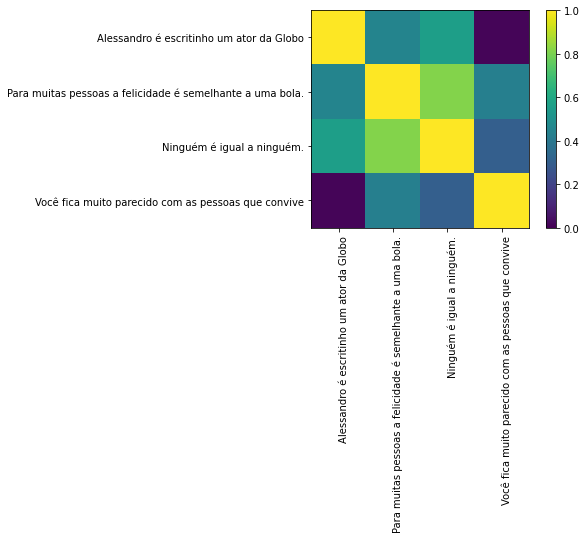

In [ ]:
from whatlies.embedding import Embedding
from whatlies.language import SpacyLanguage

lang = SpacyLanguage('pt_core_news_md')

texts = ['O Barco atravessou o banzeiro sem sofrer danos',
         'Senhor, a perseverança das ondas do mar, que fazem de cada recuo um ponto de partida para um novo avanço.',
         'As vezes é preciso ser como as ondas do mar, recuar para ganhar força.',
         'como ondas do mar']

lang[texts].plot_similarity()

Visual da similaridade de cosseno

Emb[semelhante]

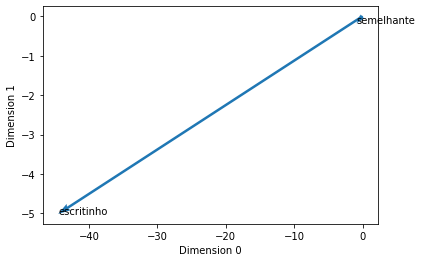

In [ ]:
from whatlies.embedding import Embedding

foo = Embedding("escritinho",nlp.vocab.get_vector('escritinho'))
bar = Embedding("semelhante",nlp.vocab.get_vector('semelhante'))

foo.plot(kind="arrow", annot=True)
bar.plot(kind="arrow", annot=True)

Emb[parecido]

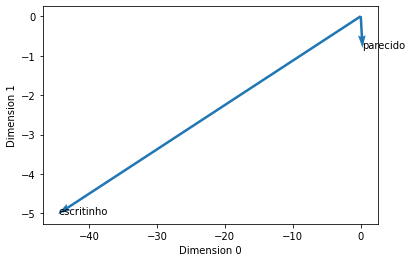

In [ ]:
foo = Embedding("escritinho",nlp.vocab.get_vector('escritinho'))
bar = Embedding("parecido",nlp.vocab.get_vector('parecido'))

foo.plot(kind="arrow", annot=True)
bar.plot(kind="arrow", annot=True)